# Evolution Plots

In [170]:
import os
import sys
from subprocess import Popen, PIPE

sys.path.append("/home/pkarpov/Sapsan")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils import line_plot, slice_plot, pdf_plot, cdf_plot

#plt.style.use('default')    

class Profiles:
    #
    # All things plotting related (+ bounce check)
    #
    def __init__(self, rank, numfiles, base_path, base_file, dataset, 
                 save_name_amend='', only_post_bounce = False, interval=[0,0], dpi=60):
        self.numfiles         = numfiles
        self.lumnue           = np.zeros((self.numfiles))
        self.times            = np.zeros((self.numfiles))
        self.base_path        = base_path
        self.dataset          = dataset
        self.base_save_path   = f'{self.base_path}{self.dataset}/plots/'
        self.movie_save_path  = f'{self.base_path}{self.dataset}/movies/'
        self.save_name_amend  = save_name_amend
        self.only_post_bounce = only_post_bounce
        self.interval         = interval
        self.dpi              = dpi
        self.cm2km            = 1e-5
        #self.progress_bar(0)
        
        self.pns_ind_ar       = np.zeros(self.numfiles)
        self.pns_x_ar         = np.zeros(self.numfiles)
        self.pns_encm_ar      = np.zeros(self.numfiles)        
        self.shock_ind_ar     = np.zeros(self.numfiles)
        self.shock_x_ar       = np.zeros(self.numfiles)
        self.shock_encm_ar    = np.zeros(self.numfiles)
        self.time_ar          = np.zeros(self.numfiles)
        self.ind_ar           = np.arange(1, self.numfiles+1)
        self.bounce_ind       = 0
        self.rank             = rank
        self.base_file        = base_file 
        
    def progress_bar(self, current, val='', done = False, bar_length=20):
        fraction = current / self.numfiles

        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '
        padding_val = int(7-len(val)) * ' '

        ending = '\n' if done == True else '\r'

        print(f'Progress: [{arrow}{padding}] {current}/{self.numfiles}, val: {val}{padding_val}', end=ending) 

    def set_paths(self, val, versus):
        self.plot_path = f'{self.base_path}{self.dataset}/plots/{val}'
        
        if not os.path.exists(self.plot_path): os.makedirs(self.plot_path)
        if versus=='r': self.plot_file = f'{self.plot_path}/{val}_r'
        elif versus=='encm': self.plot_file = f'{self.plot_path}/{val}_encm'    

    def movie(self, val, versus='r', fps=15, start=0, printout=False):      
        self.set_paths(val,versus)
        padding_val = int(7-len(val)) * ' '
        
        if self.only_post_bounce:
            name_amend = '_bounce'
            start = self.bounce_ind
        else: name_amend = ''
            
        name = f'{self.plot_file}{self.save_name_amend}'
            
        print(f'{val}{padding_val}: {name}{name_amend}.mp4')
        result = Popen(['ffmpeg', '-r', f'{fps}', '-start_number', f'{start}',
                        '-i', f'{name}_%d.png', 
                        '-vcodec', 'libx264', f'{name}{name_amend}.mp4', '-y'],
                        stdin=PIPE, stdout=PIPE, stderr=PIPE)   
        output, error = result.communicate()
        if printout: print(output, error)       
        
    def plot_convection(self):
        ax = line_plot([[self.ind_ar, self.shock_ind_ar-self.pns_ind_ar]])
        ax.get_legend().remove()
        ax.set_xlim(self.bounce_ind,self.numfiles)
        ax.set_xlabel('index')
        ax.set_ylabel('Convection Grid Size')
        ax.set_title(f'Bounce index = {self.bounce_ind}')
        plt.tight_layout()
        plt.savefig(f'{self.plot_path}/{self.save_name_amend}convgrid.png')
        return ax
        
    def plot_profile(self, i, vals, versus,
                     show_plot=False, save_plot=False, 
                     compute=False, rho_threshold = 2e11):
        file = f'{self.base_file}.{i+1}'
        file1d = f'{self.base_path}{self.dataset}/{file}'                        

        with open(file1d, "r") as file:
            line = file.readline()        
            header_vals = file.readline()
            vals_strip  = header_vals[:-1].split(' ')        
            try: time1d, bounce_time, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
            except: time1d, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
            self.lumnue[i] = rlumnue
            self.times[i]  = time1d    
            #print(file.readline())
            
        pns_ind   = int(pns_ind)-1
        shock_ind = int(shock_ind)-1
                        
        #print('Time %.2f ms'%(float(time1d)*1e3))

        ps = np.genfromtxt(file1d, skip_header=3)
        ps = np.moveaxis(ps,0,1)    
        
        # Columns in the readable files:
        # Cell  M_enclosed [M_sol]  Radius [cm]  Rho [g/cm^3]  Velocity [cm/s]  Ye  Pressure [g/cm/s^2]  Temperature [K]  Sound [cm/s] 
        ncell   = ps[0]
        encm    = ps[1]
        r       = ps[2]
        rho     = ps[3]
        v       = ps[4]
        ye      = ps[5]
        P       = ps[6]
        T       = ps[7]
        try: vsound  = ps[8]
        except: vsound = np.ones(v.shape)
        s       = ps[9] #entropy
        
        # Print out enclosed mass at 200km without plotting anything
        # if i == self.numfiles-1:         
        #     for j in range(len(cell)):
        #         if r[j] >= 2e7:
        #             print(f'at {r[j]:.2e}, mass is {encm[j]:.3e}')
        #             return
        # else: return
                    
        for val in vals:
            if versus=='encm':
                x         = encm
                xlabel    = r'$M_{enc} \; [M_{\odot}]$'
                xlim      = (0,3) #or (0,4)
                plot_type = 'semilogy'
                unit      = 1        
            elif versus=='r':
                x         = r
                xlabel    = r'$Radius \; [km]$'
                xlim      = (1e0,1e5)
                plot_type = 'loglog'
                unit      = self.cm2km
            elif versus=='Placeholder':
                x         = r
                xlabel    = r'$(V/V_{sound})^2$'
                xlim      = None
                plot_type = 'plot'
                unit      = 1
            else: print("ERROR: unknown 'versus' {versus}, trying to exit"); sys.exit()
            
            if val == 'rho': 
                y      = rho
                ylabel = r'Density $[g/cm^3]$'
                ylim   = (1e4,1e15)
                loc    = 1
            elif val == 'v':
                y      = v
                ylabel = r'Velocity $[cm/s]$'
                ylim   = (-1.2e10, 1.5e9)
                loc    = 4
                if versus == 'r': plot_type = 'semilogx'
                elif versus == 'encm': plot_type = 'plot'                
            elif val == 'vsound':
                y      = vsound
                ylabel = r'$V_{sound}$ $[cm/s]$'
                ylim   = (0, 1.4e10)
                loc    = 1
                if versus == 'r': plot_type = 'semilogx'
                elif versus == 'encm': plot_type = 'plot'   
            elif val == 'mach':
                y      = abs(v/vsound)
                ylabel = 'Mach'
                ylim   = (0,11)
                loc    = 1
                if versus == 'r': plot_type = 'semilogx'
                elif versus == 'encm': plot_type = 'plot'                                               
            elif val == 'P':
                y      = P
                ylabel = r'$P_{gas} \; [\frac{g}{cm\;s^2}]$'
                ylim   = (1e20,1e36)   
                loc    = 1
            elif val == 'T':
                y      = T
                ylabel = r'Temperature $[K]$'
                ylim   = (1e7,4e11)
                loc    = 1
            elif val == 'encm':
                y      = encm
                ylabel = r'Enclosed Mass $[M_{\odot}]$'
                ylim   = None
                loc    = 4
            elif val == 'ye':
                y      = ye
                ylabel = r'$Y_e$'
                ylim   = (0,1)
                loc    = 4   
                if versus == 'r': plot_type = 'semilogx'
                elif versus == 'encm': plot_type = 'plot' 
            elif val == 'entropy':
                y      = s
                ylabel = r'Entropy $[k_b/baryon]$'
                ylim   = None
                loc    = 4                            
            else: sys.exit(f"ERROR: unknown val {val}, trying to exit")            

            #print('diff shock', shock_ind, np.argmin(ps[4]), shock_ind-np.argmin(ps[4]))
            #shock_ind = np.argmin(ps[4])

            ax = line_plot([[x*unit, y],],
                            #[ps[2,:504]*1e0, ps[ps_ind,:504]],
                           plot_type = plot_type,
                           label     = [f'ind     {i+1}'],
                           linestyle = ['-','--','-','--'],               
                           figsize   = (10,6), 
                           dpi=self.dpi
                           )    
            
            # check if after bounce                
            if i >= self.bounce_ind:                
                
                if compute and vals.index(val)==0:
                    rt = ComputeRoutines(x, rho=rho, v=v, vsound=vsound)
                    shock_ind, shock_x = rt.shock_radius()
                    pns_ind,   pns_x   = rt.pns_radius(rho_threshold = rho_threshold)   
                    
                #print(f'shock {ps[2,int(shock_ind)]:.3e}, {shock_x:.3e}')
                
                pns_edge    = x[int(pns_ind)]*unit
                shock_front = x[int(shock_ind)]*unit
                if versus == 'r'   : line_label = '%.2e km'          
                if versus == 'encm': line_label = '%.3f $M_{\odot}$'      
                         
                ax.axvline(x=pns_edge,linestyle='-',color='r',linewidth=1,
                           label=f'PNS    {line_label%pns_edge}')
                ax.axvline(x=shock_front,linestyle='--',color='r',linewidth=1,
                           label=f'shock {line_label%shock_front}')
                
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))

            plt.legend(loc=loc)
            plt.tight_layout()
            if save_plot:        
                self.set_paths(val, versus)                
                plt.savefig(f'{self.plot_file}{self.save_name_amend}_{i+1}.png')
                
            if not show_plot: plt.close()
            
            if vals.index(val)==0:
                self.pns_ind_ar[i]    = pns_ind
                self.pns_x_ar[i]      = pns_x
                self.pns_encm_ar[i]   = encm[pns_ind]                
                self.shock_ind_ar[i]  = shock_ind
                self.shock_x_ar[i]    = shock_x
                self.shock_encm_ar[i] = encm[shock_ind]
                self.time_ar[i]       = time1d 
            
            done=True if (i==self.numfiles and vals.index(val)==(len(vals)-1)) else False
            if self.rank == 0: self.progress_bar(i+1, val, done = done)          
        return
    
class ComputeRoutines:
    #
    # Routines to calculate PNS radius and shock position
    #
    def __init__(self, x, rho, v, vsound=None):
        self.x          = x
        self.rho        = rho
        self.v          = v  
        self.vsound     = vsound      
        self.shock_ind  = 0
        self.shock_x    = 0
        self.pns_ind    = 0
        self.pns_x      = 0        
        
    def shock_radius(self):        
                                                
        for i in range(len(self.v)-1,4,-1):
            if i == len(self.v)-1: 
                #dv_old = (self.v[i]-self.v[i-1])
                dv_old = (1-self.v[i-1]/self.v[i])
                continue
                        
            #dv = (self.v[i]-self.v[i-1])                   
            dv = (1-self.v[i-1]/self.v[i])
            
            if dv==0: continue
            print(i, dv)
            if abs(dv) > abs(1.1e2*dv_old):
                print('Above!', i)
                self.shock_ind = i
                self.shock_x   = self.x[self.shock_ind]
                #break
            
            dv_old = dv
                                
        # mach = abs(self.v/self.vsound)
        # maxmach = np.amax(mach)
        
        # for i in range(np.argmin(self.v),-1,-1):       
        #     if mach[i] < maxmach/2:
        #         self.shock_ind = i
        #         self.shock_x   = self.x[self.shock_ind]
        #         break
    
        print('shock position: %.2e'%self.shock_x, self.shock_ind)
        return self.shock_ind, self.shock_x
        
    def pns_radius(self, rho_threshold = 2e11):      
          
        for i in range(len(self.rho)):            
            if self.rho[i] > rho_threshold:
                self.pns_ind = i
                self.pns_x   = self.x[i]
                
        return self.pns_ind, self.pns_x        

1493 -0.0073291452503332355
1492 0.009449116507606492
1491 -0.022321854430983556
1490 -0.00699822711579734
1489 0.012879911045218684
1488 0.013329578522481955
1487 -0.010274950052326037
1486 -0.022506827384876082
1485 0.005986369497144928
1484 0.010006485685166266
1483 0.011417875526438914
1482 -0.022342137650288807
1481 -0.007130289841652093
1480 0.009746230231702846
1479 0.00974930362116988
1478 -0.008063759962494199
1477 -0.017765789228908924
1476 0.010327179674648135
1475 0.007018191892141479
1474 0.008834743792429989
1473 -0.027115781572527586
1472 -0.011144605828080856
1471 0.020598066672689486
1470 0.012821695415552115
1469 -0.0012147262193982211
1468 -0.03565095660289308
1467 -0.006578354510228035
1466 0.018263205013428818
1465 0.020609155571767235
1464 -0.006797020484171412
1463 -0.015259409969481164
1462 0.04618327564219349
1461 0.06003247063317729
1460 0.03264447695683981
1459 -0.019588072806713486
1458 -0.06205447278421028
1457 0.030135790494665415
1456 0.04584320902463168


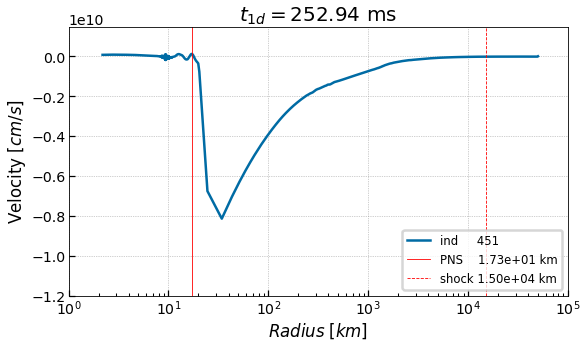

In [171]:
%matplotlib inline

vals             = [
                    # 'rho', 
                     'v',
                    # 'P',
                    # 'T',
                    # 'encm',
                    # 'vsound',
                    # 'ye',
                    #'mach',
                    # 'entropy',
                    ]   

versus           = 'r'
masses           = [13.0]
# --- Paths & Names ---
#datasets         = [f's{m}_collapse' for m in masses]
datasets         = [f's{m}_g1.5k_c0.5k_p0.3k' for m in masses]
dataset          = datasets[0]
#base_path        = '/home/pkarpov/scratch/1dccsn/sfho_s/test_extrema/'
base_path        = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/'
base_file        = f'DataOut_read'
save_name_amend  = ''

numfiles = len([filename for filename in os.listdir(f'{base_path}{dataset}') if base_file in filename])
numfiles = 8941

pf = Profiles(0,numfiles = numfiles, base_path = base_path, base_file=base_file, dataset = dataset, 
              save_name_amend=save_name_amend, only_post_bounce = False)

ind = 450#650#8751#8452
for i in range(ind,ind+1):  
    #i = 247 #hrg looks good! from 50 cells to 300+ while res diffs from ~1800 to ~3600
    #versus can be either 'r' or 'encm'
    pf.plot_profile(i             = i,
                    vals          = vals, 
                    versus        = versus, 
                    show_plot     = True, 
                    save_plot     = False,
                    compute       = True,
                    rho_threshold = 1e13,
                   )   
    break     

rho    : /home/pkarpov/COLLAPSO1D/project/1dmlmix/output/DataOut/plots/rho/rho_r_bounce.mp4
v      : /home/pkarpov/COLLAPSO1D/project/1dmlmix/output/DataOut/plots/v/v_r_bounce.mp4
P      : /home/pkarpov/COLLAPSO1D/project/1dmlmix/output/DataOut/plots/P/P_r_bounce.mp4
T      : /home/pkarpov/COLLAPSO1D/project/1dmlmix/output/DataOut/plots/T/T_r_bounce.mp4


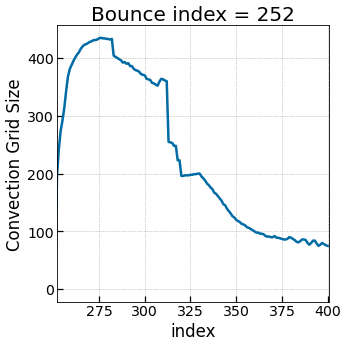

In [28]:
ax = pf.plot_convection()
for val in vals: pf.movie(val,fps=2)  

In [89]:
size = 4
numfiles = 100

interval_size = int(numfiles/size)
leftover = numfiles%size

interval = np.array([[i*interval_size,i*interval_size+interval_size] for i in range(size)])

if leftover != 0:
    shift = 0
    for i in range(size):        
        interval[i,0] += shift
        if leftover != 0:
            shift+=1
            leftover -=1             
        interval[i,1] += shift        

interval


array([[  0,  25],
       [ 25,  50],
       [ 50,  75],
       [ 75, 100]])

In [7]:
import numpy as np

# at ~200 km
enclmass = np.array([0.19125454912185705, 0.12097714135646841, 5.7727474367618624E-002])
masses = np.array([9,15,20])

print(enclmass[:]/masses[:])
print((enclmass[1]-enclmass[2])/5)
print((enclmass[0]-enclmass[1])/6)


[0.02125051 0.00806514 0.00288637]
0.012649933397769958
0.01171290129423144


In [2]:
masses = [1,2,3]
[1.4 for i in range(len(masses))]

[1.4, 1.4, 1.4]

In [95]:
x = np.arange(1,11.1, 0.1)
#print(x)
grid = 100
leftover = 100
deltam = np.zeros(grid+1+1)
deltam[0] = 0.1
enclmass = 0
dfracs = np.sum(deltam[0]*x[:]/x[0])
print(dfracs, grid, len(x))
deltam_growth = leftover/dfracs
for i in range(1,leftover+1):    
    deltam[i] = deltam[0]*(x[i]/x[0])*deltam_growth
    enclmass += deltam[i]
    
    
    #print(step, deltam[i], x[i])
print(enclmass, deltam_growth)


60.60000000000005 100 101
99.83498349834984 1.6501650165016488


1.5944511836884159


/tmp/ipykernel_5992/3050302134.py:21: RuntimeWarning: divide by zero encountered in log
  yvals = np.array([np.log(x), x, (1+0.05)**x, x**1.1])


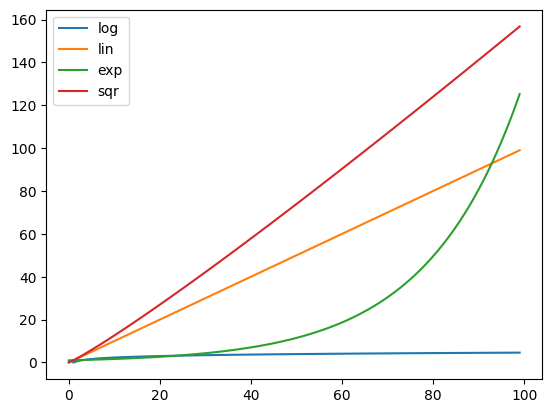

In [2]:
import matplotlib.pyplot as plt
import numpy as np

deltam = np.zeros(10)
focusm = 1.2605739682476527E-004
deltam[0] = focusm

r = 3.6254867650288243E-002   
focusr = 2.0007805423749334E-002
l = (np.log(r/focusr)+1)
#l = np.log(deltam[0]/focusm)
print(l)
# for i in range(9):
#     deltam[i+1] = focusm*(abs(np.log(deltam[i]-focusm))+1)
#     print(np.log(deltam[i]-focusm))
# #print(f'{deltam[]:.2e}')
# print(deltam)

grid = 100
x = np.arange(grid)
yvals = np.array([np.log(x), x, (1+0.05)**x, x**1.1])
labels = ['log', 'lin', 'exp', 'sqr']
for i,y in enumerate(yvals):
    #plt.semilogy(x,y,label = labels[i])
    plt.plot(x,y,label = labels[i])
    plt.legend()

In [4]:
mass = 0.9
deltam_conv = 3e-4
deltam = deltam_conv*10
pns_grid = 1048

enclmass = 0

rate = 1-(deltam_conv/deltam)**(1/pns_grid)
print(deltam_conv, deltam, (deltam_conv/deltam), (deltam_conv/deltam)**(1/pns_grid))
print(rate)

#for i in range(1,pns_grid):        
counter = 0
while (enclmass < mass):
    enclmass += dm
    rate = 1-(deltam_conv/deltam)**(1/pns_grid)
    dm = deltam*(1-rate)**counter
    counter +=1
    
print(enclmass, dm, deltam_conv, counter)

0.0003 0.0029999999999999996 0.1 0.9978052887280536
0.00219471127194637
0.9006116950654756 0.0010245147168290488 0.0003 490


In [133]:
import numpy as np

counter = 0
mass = 0.9
enclmass=0

n = 500
deltam_conv = 8e-4
mass = 0.9
a = mass*2/(n*deltam_conv)-1

deltam = deltam_conv*a

rate = (deltam-deltam_conv)/n
print(n, a, rate)

for i in range(0,n):
    enclmass += deltam-rate*i    
#enclmass -= deltam
    
# while (enclmass < mass):
#     deltam-=rate
#     enclmass += deltam 
#     counter +=1
#     if counter == 10000: break
    
print(deltam, enclmass)

500 3.5 4e-06
0.0028 0.901


In [77]:
deltam_conv = 3e-4
deltam = deltam_conv*10
mass = 0.9
n = 2*mass/(deltam+deltam_conv)
#n = (2*mass-deltam+deltam_conv)/(deltam+deltam_conv)
print(n)

n = 500
dmc = 3e-4
mass = 0.9
a = mass*2/(n*dmc)-1
a

545.4545454545455


11.0

In [65]:
import sys
c = 7.89
adjust = 10
lim = c
n=1e-3
init = False
counter = 0
low = 0

while abs(n-c)>0.01*c:
    counter +=1
    if n < lim:
        print('too low!', n, adjust, high)        
        
        print('new low', low)
        if init:
            low = adjust    
            n = n/adjust            
            adjust = adjust+(high-adjust)*0.5
        n = n*adjust    
    else:
        print('high', n, adjust, low)
        high = adjust
        n = n/adjust
        
        if not init:
            
            init = True                
        adjust = adjust-(adjust-low)*0.5  
        n = n*adjust    
        
    if init: 
        print('end loop:', counter,init, n, adjust, low, high)
        print('-------')
    if counter == 10: sys.exit()
print('Done!',counter, n, c)

too low! 0.001 10 10.0
new low 0
too low! 0.01 10 10.0
new low 0
too low! 0.1 10 10.0
new low 0
too low! 1.0 10 10.0
new low 0
high 10.0 10 0
end loop: 5 True 5.0 5.0 0 10
-------
too low! 5.0 5.0 10
new low 0
end loop: 6 True 7.5 7.5 5.0 10
-------
too low! 7.5 7.5 10
new low 5.0
end loop: 7 True 8.75 8.75 7.5 10
-------
high 8.75 8.75 7.5
end loop: 8 True 8.125 8.125 7.5 8.75
-------
high 8.125 8.125 7.5
end loop: 9 True 7.8125 7.8125 7.5 8.125
-------
Done! 9 7.8125 7.89


# Legacy

In [11]:
#%matplotlib inline
%matplotlib auto

%matplotlib inline
import os
import sys

sys.path.append("../../../")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
numfiles = 400#2284
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))

#for i in range(226,numfiles):  
for i in range(numfiles):  
    #i = 390
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']           
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.genfromtxt(file1d, skip_header=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 4
    ax = line_plot([[ps[1], ps[ps_ind]],],
                    #[ps[2,:504]*1e0, ps[ps_ind,:504]],                    
                   #plot_type='semilogy',
                   #plot_type='semilogx',
                   plot_type='plot',
                   #plot_type='loglog',
                   label = [f'ind    {i+1}'],
                   linestyle=['-','--','-','--'],               
                   figsize=(10,6))    
    if float(time1d) >= 0.2397:
        edgerho = 2e11
        edger=0
        lenrho = len(ps[3])-1
        for j in range(lenrho):
            if ps[3,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        print('shock', ps[1,int(shock_ind)])
        ax.axvline(x=edgeenc,linestyle='-',color='r',linewidth=1, label = 'PNS %.3f $M_{sol}$'%edgeenc)
        #ax.axvline(x=edger*1e-5,linestyle='-',color='r',linewidth=1, 
        #           label = 'PNS    %.2e km'%(edger*1e-5))
        ax.axvline(x=ps[1,int(shock_ind)],linestyle='--',color='r',
                   linewidth=2, label = 'shock %.3f $M_{sol}$'%(ps[1,int(shock_ind)]))
    ax.set_xlabel(r'$M_{enc} \; [M_{sol}]$')
    #ax.set_xlabel(r'$Radius \; [cm]$')
    #ax.set_xlabel(r'$Radius \; [km]$')
    #ax.set_ylabel(r'$P_{gas} \; [\frac{g}{cm\;s^2}]$')
    ax.set_ylabel(r'Velocity $[cm/s]$')
    #ax.set_ylabel(r'Density $[g/cm^3]$')
    ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))
    ax.set_xlim((0,3)) #M_enc
    ax.set_ylim((-5e9, 1.5e9)) #velocity
    #ax.set_xlim((1e4,1e10)) #radius in cm
    #ax.set_xlim((1e0,1e5)) #radius in km
    #ax.set_xlim((0,4)) #M_enc 2
    #ax.set_ylim((1e20,1e36)) #pressure
    #ax.set_ylim((1e4,1e15)) #density

    plt.legend()
    plt.tight_layout()
    plt.savefig('/home/pkarpov/scratch/plots/s19.0/velocity/velocity_encm%d.png'%(i+1))
    plt.close()
    #break#if i == 255: break

Using matplotlib backend: <object object at 0x7fdef67f9390>


FileNotFoundError: [Errno 2] No such file or directory: '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.1'

pns shock 382 406 24
pns shock 420 432 12
pns shock 456 458 2
pns shock 513 515 2
pns shock 632 637 5
pns shock 710 747 37
pns shock 710 819 109
pns shock 691 879 188
pns shock 698 917 219
pns shock 527 945 418
pns shock 671 969 298
pns shock 687 987 300
pns shock 710 1000 290
pns shock 710 1011 301
pns shock 710 1019 309
pns shock 802 1027 225
pns shock 897 1033 136
pns shock 932 1039 107
pns shock 961 1043 82
pns shock 1009 1047 38
pns shock 1034 1051 17
pns shock 1032 1056 24
pns shock 1032 1061 29
pns shock 1023 1065 42
pns shock 1005 1069 64
pns shock 1039 1071 32
pns shock 1033 1073 40
pns shock 1027 1076 49
pns shock 1026 1078 52
pns shock 1030 1079 49
pns shock 1029 1080 51
pns shock 1026 1081 55
pns shock 1027 1081 54
pns shock 1029 1082 53
pns shock 1033 1082 49
pns shock 1031 1083 52
pns shock 1032 1084 52
pns shock 1030 1085 55
pns shock 1030 1085 55
pns shock 1031 1086 55
pns shock 1032 1087 55
pns shock 1034 1087 53
pns shock 1035 1088 53
pns shock 1034 1089 55
pns shock 

(240.0, 320.0)

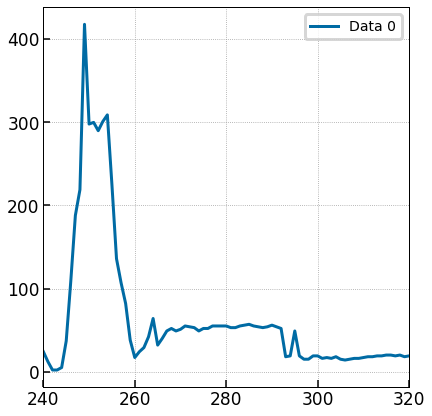

In [ ]:
%matplotlib inline
#%matplotlib auto

%matplotlib inline
import os
import sys

sys.path.append("../../../")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
#numfiles = 396 #run4 2284
numfiles = 360 # hrg
start = 226
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))
conv_region = []
bounce_ind = -1
for i in range(start,numfiles):  
    #i = 390
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hrg/DataOut_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']   
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    #print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.genfromtxt(file1d, skip_header=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 4
       
    if float(time1d) >= 0.2397:
        if bounce_ind == -1: bounce_ind = i
        edgerho = 2e11
        edger=0
        lenrho = len(ps[3])-1
        for j in range(lenrho):
            if ps[3,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        conv_region.append(int(shock_ind)-(lenrho-j))
        print('pns shock', lenrho-j, int(shock_ind), int(shock_ind)-(lenrho-j)) 
ax = line_plot([[times[bounce_ind:i+1]*1000, conv_region]])
ax.set_xlim((240,320))

Text(0.5, 1.0, 'Grid Size: 3667')

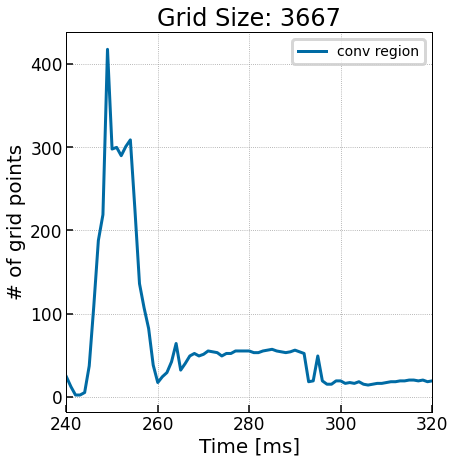

In [13]:
ax = line_plot([[times[bounce_ind:i+1]*1000, conv_region]], label=['conv region'])
ax.set_xlim((240,320))
ax.set_xlabel('Time [ms]')
ax.set_ylabel('# of grid points')
ax.set_title('Grid Size: 3667')

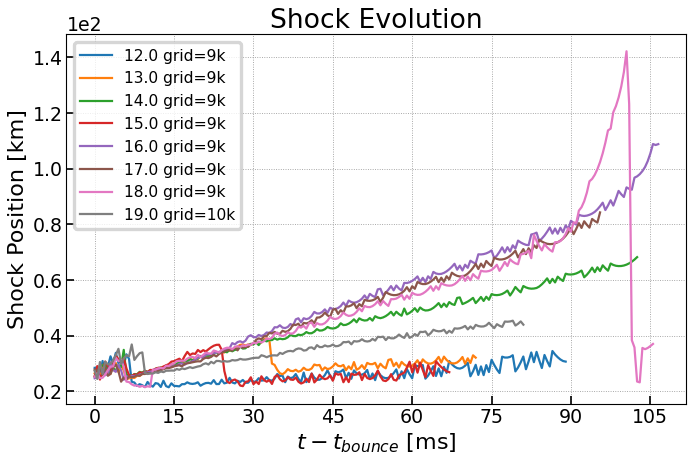

In [2]:
import os
import sys

sys.path.append("/home/pkarpov/Sapsan")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sapsan.utils import line_plot, plot_params

style = 'default'#'tableau-colorblind10'
mpl.style.use(style)
mpl.rcParams.update(plot_params()) 

base_path        = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/'

fig = plt.figure(figsize=(10,6), dpi=80)
ax  = fig.add_subplot(111)

# masses           = [12.0,12.0,12.0,12.0,12.0]
# datasets         = [f's{m}_g6k_c5k_p0.3k' for m in masses]

# for i, dataset in enumerate(datasets): 
#     file1d = f'{base_path}{dataset}/plots/evolution.txt'
#     vals = np.genfromtxt(file1d, skip_header=1)
#     vals = np.moveaxis(vals,0,1)
#     ax.plot((np.trim_zeros(vals[0])-np.trim_zeros(vals[0])[0])*1e3, np.trim_zeros(vals[5]), label = f'{masses[i]} grid=6k')

masses   = [12.0,13.0,14.0,15.0,16.0,17.0,18.0]
# masses   = [11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0]
datasets = [f's{m}_g9k_c8.4k_p_0.3k' for m in masses]
# datasets = [f's{m}_g1.5k_c0.5k_p0.3k' for m in masses]
# datasets = [f's{m}_g2k_c1k_p0.3k' for m in masses]
# datasets = ['s12.0_g1.5k_c0.5k_p0.3k',
#             's12.0_g2k_c1k_p0.3k',
#             's12.0_g4k_c3k_p0.3k',
#             's12.0_g6k_c5k_p0.3k',
#             's12.0_g9k_c8.4k_p_0.3k']
grids    = [1.5, 2, 4, 6, 9] 
grid     = 9

for i, dataset in enumerate(datasets): 
    file1d = f'{base_path}{dataset}/plots/evolution.txt'
    vals = np.genfromtxt(file1d, skip_header=1)
    vals = np.moveaxis(vals,0,1)
    ax.plot((np.trim_zeros(vals[0])-np.trim_zeros(vals[0])[0])*1e3, np.trim_zeros(vals[5])*1e-5, 
            linewidth=2, 
            #label = f'grid={grids[i]}k')
            label = f'{masses[i]} grid={grid}k')

masses           = [19.0]
datasets         = [f's{m}_g10k_c9.4k_p0.3k' for m in masses]

for i, dataset in enumerate(datasets): 
    file1d = f'{base_path}{dataset}/plots/evolution.txt'
    vals = np.genfromtxt(file1d, skip_header=1)
    vals = np.moveaxis(vals,0,1)
    ax.plot((np.trim_zeros(vals[0])-np.trim_zeros(vals[0])[0])*1e3, np.trim_zeros(vals[5])*1e-5, 
            linewidth=2,
            label = f'{masses[i]} grid=10k')

ax.legend(loc=0)
# ax.set_xlim(0,120)
# ax.set_ylim(0.2e2,0.8e2)
ax.set_xlabel(r'$t-t_{bounce}$ [ms]')
ax.set_ylabel('Shock Position [km]')
#ax.set_title("Shock Evolution of 12 $M_{\odot}$")
ax.set_title("Shock Evolution")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# plt.savefig(f'{base_path}shock_evolution_{grid}k.png')
# plt.savefig(f'{base_path}shock_evolution_hr.png')
# plt.savefig(f'{base_path}shock_evolution_s12.png')
    

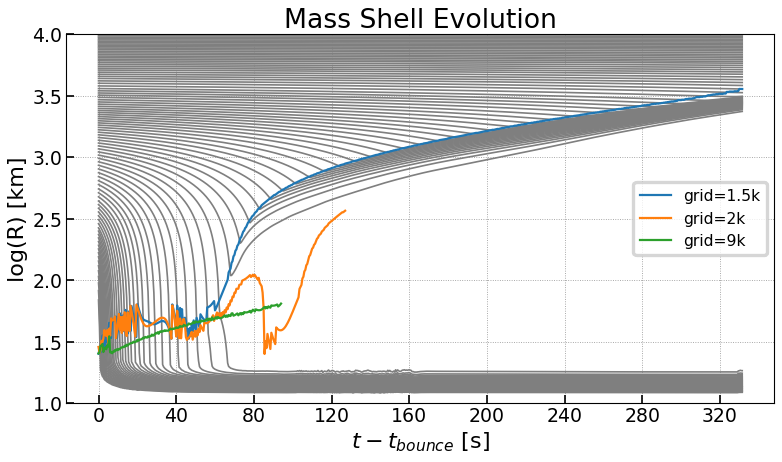

In [200]:
class shells:
    def __init__(self, time_ar, shell_ar, dpi = 80):
        self.time_ar  = time_ar
        self.shell_ar = shell_ar
        self.dpi      = dpi
        self.cm2km    = 1e-5
        self.s2ms     = 1e3
            
    
    def plot_format(self, series, xlabel, ylabel, title, save_path, 
                          show_plot=True, plot_style = 'plot', bounce_lim=False,
                          label=None, ax=None, marker='.', linewidth=1.5):                       
        
        #style = 'tableau-colorblind10'
        style = 'default'
        mpl.style.use(style)
        mpl.rcParams.update(plot_params())  
        
        if not label: label = [f'None' for i in range(len(series))]
        
        if ax==None:            
            fig = plt.figure(figsize=(10,6), dpi=self.dpi)
            ax  = fig.add_subplot(111)        
        for idx, data in enumerate(series): 
            if   plot_style == 'plot'    : plot_func = ax.plot
            elif plot_style == 'semilogx': plot_func = ax.semilogx
            elif plot_style == 'semilogy': plot_func = ax.semilogy
            elif plot_style == 'loglog'  : plot_func = ax.loglog  
                      
            plot_func(data[0], data[1], linewidth=linewidth, marker=marker, label=label[idx])
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            
        plt.tight_layout()
        if 'None' not in label: ax.legend(loc=0)
        
        #plt.savefig(save_path)        
        if not show_plot: plt.close()        
         
        return ax     
    
    def plot_shells(self, ax, show_plot=False):                  
        plot_data = []
        
        for s in range(np.shape(self.shell_ar)[0]):
            plot_data.append([(self.time_ar-self.time_ar[0])*self.s2ms, 
                              np.log10(self.shell_ar[s]*self.cm2km)])
                                               
        for idx, data in enumerate(plot_data): 
            ax.plot(data[0], data[1], linewidth=1.5, color='tab:gray')    
                                                
        return ax
    
base_path        = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/'

#masses           = [12.0,13.0,14.0,15.0,16.0,17.0,18.0]
#datasets         = [f's{m}_g9k_c8.4k_p_0.3k' for m in masses]

masses           = [19.0]
datasets         = [f's{m}_g10k_c9.4k_p0.3k' for m in masses]

datasets = ['s12.0_g1.5k_c0.5k_p0.3k',
            's12.0_g2k_c1k_p0.3k',
            's12.0_g4k_c3k_p0.3k',
            's12.0_g6k_c5k_p0.3k',
            's12.0_g9k_c8.4k_p_0.3k']

grids    = [1.5, 2, 4, 6, 9]

datasets = ['s14.0_g1.5k_c0.5k_p0.3k',
            's14.0_g2k_c1k_p0.3k',                        
            's14.0_g9k_c8.4k_p_0.3k'] 

grids    = [1.5, 2, 9]

plot_data = []
labels    = []

fig = plt.figure(figsize=(10,6), dpi=80)
ax  = fig.add_subplot(111) 

for i, dataset in enumerate(datasets): 
    if i == 0:
        file1d = f'{base_path}{dataset}/plots/evolution_mass_shells.txt'
        vals = np.genfromtxt(file1d, skip_header=1)
        vals = np.moveaxis(vals,0,1)
            
        time_ar  = np.trim_zeros(vals[0])
        shell_ar = np.array([np.trim_zeros(j) for j in vals[1:]])
            
        sh = shells(time_ar=time_ar, shell_ar=shell_ar)
        ax = sh.plot_shells(ax)
        ax.set_ylim(1,4)
    
    # Grab shock radius
    file1d = f'{base_path}{dataset}/plots/evolution.txt'
    vals = np.genfromtxt(file1d, skip_header=1)
    vals = np.moveaxis(vals,0,1)
    time_ar    = np.trim_zeros(vals[0]) 
    shock_x_ar = np.trim_zeros(vals[5])    
    
    plot_data.append([(time_ar-time_ar[0])*sh.s2ms, 
                      np.log10(shock_x_ar*sh.cm2km)])
    
    labels.append(f'grid={grids[i]}k')        
    
#save_path = f'{self.base_save_path}{self.save_name_amend}mass_shells.png'
save_path = f'{base_path}mass_shells_s14.png'
ax = sh.plot_format(series    = plot_data,
                    xlabel    = r'$t-t_{bounce}$ [s]', 
                    ylabel    = r'log(R) [km]', 
                    title     = f'Mass Shell Evolution',
                    save_path = save_path, 
                    show_plot = True,
                    label     = labels,
                    ax        = ax,
                    marker    = '',
                    linewidth = 2)   

# plt.savefig(save_path)